# Bayesian Neural Networks

Neural networks are powerful approximators. However, standard approaches for learning this approximators does not take into account the inherent uncertainty we may have when fitting a model. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from tensorflow_probability import edward2 as ed

/Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/andresmasegosa/Dropbox/infer/tmp/inferpy/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/

## Data

We use some fake data. As neural nets of even one hidden layer 
can be universal function approximators, we can see if we can 
train a simple neural network to fit a noisy sinusoidal data, like this:
    

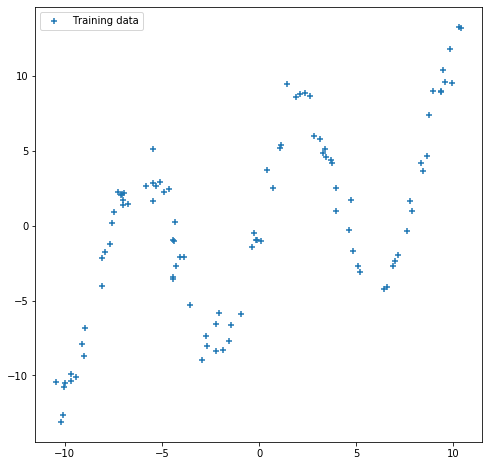

In [2]:
NSAMPLE = 100
x_train = np.float32(np.random.uniform(-10.5, 10.5, (1, NSAMPLE))).T
r_train = np.float32(np.random.normal(size=(NSAMPLE,1),scale=1.0))
y_train = np.float32(np.sin(0.75*x_train)*7.0+x_train*0.5+r_train*1.0)

plt.figure(figsize=(8, 8))
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.legend();

## Training a neural network

We employ a simple feedforward network with 20 hidden units to try to fit the data. 


In [3]:
x = tf.placeholder(dtype=tf.float32, shape=[None,1])
y = tf.placeholder(dtype=tf.float32, shape=[None,1])


NHIDDEN = 20
W = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([1,NHIDDEN], stddev=1.0, dtype=tf.float32))

W_out = tf.Variable(tf.random_normal([NHIDDEN,1], stddev=1.0, dtype=tf.float32))
b_out = tf.Variable(tf.random_normal([1,1], stddev=1.0, dtype=tf.float32))

hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
y_out = tf.matmul(hidden_layer,W_out) + b_out

lossfunc = tf.nn.l2_loss(y_out-y);


train_op = tf.train.AdamOptimizer(0.01).minimize(lossfunc)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

NEPOCH = 1000
for i in range(NEPOCH):
  sess.run(train_op,feed_dict={x: x_train, y: y_train})
  if i%100==0: 
        print(sess.run(lossfunc,feed_dict={x: x_train, y: y_train}))


3176.3455
1038.1906
919.3653
779.0373
618.3319
456.45087
318.0953
215.63321
147.22798
104.45438


We see that the neural network can fit this sinusoidal data quite well, as expected. 

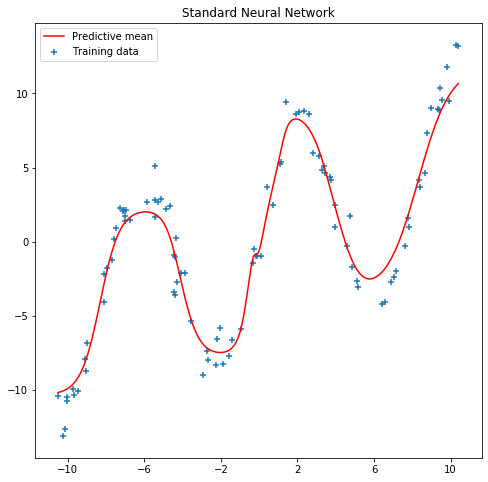

In [4]:
x_test = np.float32(np.arange(-10.5,10.5,0.1))
x_test = x_test.reshape(x_test.size,1)
y_test = sess.run(y_out,feed_dict={x: x_test})

plt.figure(figsize=(8, 8))
plt.plot(x_test, y_test, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.xticks(np.arange(-10., 10.5, 4))
plt.title('Standard Neural Network')
plt.legend();
sess.close()

However this model is unable to capture the uncertainty in the model. For example, when making predictions about a single point (e.g. around x=2.0) we can see we do not account aobut the inherent noise there is in this predictions. In next section, we will what happen when we introduce a Bayesian approach using [Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2). 

## Bayesian Learning of Neural Networks

[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a distribution over variables that are consistent with the observed data.

In Bayesian learning, the weights of the network are `random variables`. The output of the nework is another `random variable`. And the random variable of the output is the one that implicitlyl defines the ``loss function``. So, when making Bayesian learning we do not define ``loss functions``, we do define ``random variables``. For more information you can check [this talk](https://www.cs.ox.ac.uk/people/yarin.gal/website/PDFs/2017_OReilly_talk.pdf) and this [paper](https://arxiv.org/abs/1908.03442).

In [Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2), we first define our model, where the weights of the neural network are defined as random variables. Second, the input `x` and output `y` are also define as random variables. More precisely, the output `y` is defined as a Gaussian random varible. The mean of the Gaussian is the output of the neural network. 

In [5]:
def model(NHIDDEN,NSAMPLE):
    W = ed.Normal(loc = tf.zeros([1,NHIDDEN]), scale=1., name="W")
    b = ed.Normal(loc = tf.zeros([1,NHIDDEN]), scale=1., name="b")

    W_out = ed.Normal(loc = tf.zeros([NHIDDEN,1]), scale=1., name="W_out")
    b_out = ed.Normal(loc = tf.zeros([1,1]), scale=1., name="b_out")

    x = ed.Normal(loc = tf.zeros([NSAMPLE,1]), scale = 1.0, name="x")
    hidden_layer = tf.nn.tanh(tf.matmul(x, W) + b)
    out = tf.matmul(hidden_layer,W_out) + b_out
    y = ed.Normal(loc = out , scale= 1.0, name="y")
    
    return W,b,W_out,b_out,x,y

To perform Bayesian learning, we resort the scalable variational methods available in Edward2, which require the definition of a `q` model. For details,see the documentation about [Edward2](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/experimental/edward2). For a deeper theoretical despcription, read this [paper](https://arxiv.org/abs/1908.03442).

In [6]:
def qmodel(NHIDDEN):
    W_loc = tf.Variable(tf.random_normal([1,NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    b_loc = tf.Variable(tf.random_normal([1,NHIDDEN], 0.0, 0.05, dtype=tf.float32))
    W_scale = tf.nn.softplus(tf.Variable(tf.random_normal([1,NHIDDEN], -10., stddev=0.05 ,dtype=tf.float32)))+0.01
    b_scale = tf.nn.softplus(tf.Variable(tf.random_normal([1,NHIDDEN],  -10., stddev=0.05 ,dtype=tf.float32)))

    qW = ed.Normal(W_loc, scale = W_scale, name="W")
    qb = ed.Normal(b_loc, scale = b_scale, name="b")

    W_out_loc = tf.Variable(tf.random_normal([NHIDDEN,1], 0.0, 0.05, dtype=tf.float32))
    b_out_loc = tf.Variable(tf.random_normal([1,1], 0.0, 0.05, dtype=tf.float32))
    W_out_scale = tf.nn.softplus(tf.Variable(tf.random_normal([NHIDDEN,1],  -10., stddev=0.05, dtype=tf.float32)))
    b_out_scale = tf.nn.softplus(tf.Variable(tf.random_normal([1,1],  -10., stddev=0.05, dtype=tf.float32)))

    qW_out = ed.Normal(W_out_loc, scale = W_out_scale, name="W_out")
    qb_out = ed.Normal(b_out_loc, scale = b_out_scale, name="b_out")
    
    return qW,qb,qW_out,qb_out

In [7]:
W,b,W_out,b_out,x,y = model(NHIDDEN,1000)

qW,qb,qW_out,qb_out = qmodel(NHIDDEN)

with ed.interception(ed.make_value_setter(W=qW,b=qb,W_out=qW_out,b_out=qb_out,x=x_train,y=y_train)):
    pW,pb,pW_out,pb_out,px,py = model(NHIDDEN,NSAMPLE)

energy = tf.reduce_sum(pW.distribution.log_prob(pW.value)) + \
         tf.reduce_sum(pb.distribution.log_prob(pb.value)) + \
         tf.reduce_sum(pW_out.distribution.log_prob(pW_out.value)) + \
         tf.reduce_sum(pb_out.distribution.log_prob(pb_out.value))+ \
         tf.reduce_sum(py.distribution.log_prob(py.value))

entropy = tf.reduce_sum(qW.distribution.log_prob(qW.value)) + \
          tf.reduce_sum(qb.distribution.log_prob(qb.value)) + \
          tf.reduce_sum(qW_out.distribution.log_prob(qW_out.value)) + \
          tf.reduce_sum(qb_out.distribution.log_prob(qb_out.value))

elbo = energy - entropy


In [8]:
num_epochs=5000
verbose=True
sess = tf.Session()
optimizer = tf.train.AdamOptimizer(0.01)
t = []
train = optimizer.minimize(-elbo)
init = tf.global_variables_initializer()
sess.run(init)

for i in range(num_epochs+1):
    t.append(sess.run(elbo))
    sess.run(train)
    if verbose:
        if i % 10 == 0: print(".", end="", flush=True)
        if i % 100 == 0:
            str_elbo = str(-t[-1])
            print("\n" + str(i) + " epochs\t" + str_elbo, end="", flush=True)


.
0 epochs	2384.4429..........
100 epochs	1671.2708..........
200 epochs	1501.6433..........
300 epochs	1119.3574..........
400 epochs	782.8988..........
500 epochs	640.7206..........
600 epochs	568.1824..........
700 epochs	515.6074..........
800 epochs	471.70602..........
900 epochs	495.4765..........
1000 epochs	477.70837..........
1100 epochs	540.8452..........
1200 epochs	437.87894..........
1300 epochs	461.0063..........
1400 epochs	449.6501..........
1500 epochs	469.21536..........
1600 epochs	439.79395..........
1700 epochs	452.75925..........
1800 epochs	441.3797..........
1900 epochs	469.5017..........
2000 epochs	449.37714..........
2100 epochs	470.0158..........
2200 epochs	465.39853..........
2300 epochs	441.55762..........
2400 epochs	453.27737..........
2500 epochs	433.28738..........
2600 epochs	445.8512..........
2700 epochs	444.6891..........
2800 epochs	463.67648..........
2900 epochs	507.9249..........
3000 epochs	464.28143..........
3100 epochs	447.49146..........


As can be seen in the nex figure, the output of our model is not deterministic. So, we can caputure the uncertainty in the data. See for example what happens now with the predictions at the point `x=2.0`. See also what happens with the uncertainty in out-of-range predictions.

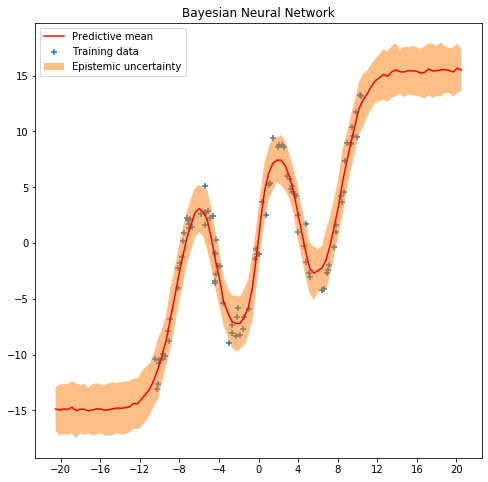

In [9]:
x_test = np.linspace(-20.5, 20.5, NSAMPLE).reshape(-1, 1)

with ed.interception(ed.make_value_setter(W=qW,b=qb,W_out=qW_out,b_out=qb_out,x=x_test)):
    pW,pb,pW_out,pb_out,px,py = model(NHIDDEN,NSAMPLE)

plt.figure(figsize=(8, 8))
y_pred_list = []
for i in range(100):
    y_pred_list.append(sess.run(py))

y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(x_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(x_train, y_train, marker='+', label='Training data')
plt.fill_between(x_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.xticks(np.arange(-20., 20.5, 4))
plt.title('Bayesian Neural Network')
plt.legend();